# Import Modules

In [1]:
import numpy as np
from fourrooms import Fourrooms
from IPython.display import clear_output
from aoaoc_classes import *
import matplotlib.pyplot as plt
from visualize import Visualization

# HyperParameters

In [9]:
# Replace the command line argparse
class Arguments:
    def __init__(self):
        # Numbers
        self.nepisodes=4000
        self.nruns=1
        self.nsteps=2000
        self.noptions=2
        
        # Learning Rates
        self.lr_term=0.1
        self.lr_intra=0.25
        self.lr_critic=0.5
        self.lr_critic_pseudo=0.5
        self.lr_criticA=0.5
        self.lr_criticA_pseudo=0.5
        self.lr_attend=0.02
        
        # Environment Parameters
        self.discount=0.99
        self.deterministic = False
        self.punishEachStep = True
        self.modified = True
        
        # Attention Parameters
        self.h_learn = False
        self.normalize = True
        
        # Distraction Parameters
        self.xi=0.
        self.n=0.5
        
        # Policy Parameters
        self.epsilon=1e-1
        self.temp=1.
        
        # Objective Parameters
        self.wo1 = 1.   #q
        self.wo2 = 1.    #cosim
        self.wo3 = 0.    #entropy
        self.wo4 = 0.    #size
        self.wo4p = 2
        
        # Randomness Parameters
        self.seed=2222
        self.seed_startstate=1111
        
        # Display Parameters
        self.showMap = True
        self.showAttention = False
        
        # Other Parameters
        self.baseline=True
        self.dc = 0.2
        
        
args = Arguments()

# Run

## Set up

In [3]:
rng = np.random.RandomState(args.seed)
env = Fourrooms(args.seed_startstate, args.punishEachStep, args.deterministic, args.modified)
R = 50.

possible_next_goals = [68, 69, 70, 71, 72, 78, 79, 80, 81, 82, 88, 89, 90, 91, 92, 93, 99, 100, 101, 102, 103]

features = Tabular(env.observation_space)
nfeatures, nactions = len(features), env.action_space

viz = Visualization(env, args, nactions)

## Main loop

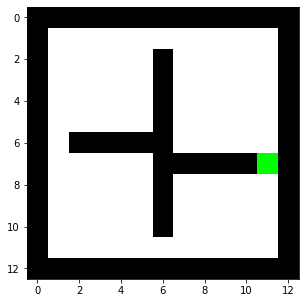

Run 0 episode 3999 steps 3 cumreward 44.0 avg. duration 1.6666666666666667 switches 3


In [10]:
for run in range(args.nruns):
    # Set up classes
    policy_over_options = POO(rng, nfeatures, args)
    CoSimObj.reset()
    options = [Option(rng, nfeatures, nactions, args, R, policy_over_options, i) for i in range(args.noptions)]

    # Loop through games
    for episode in range(args.nepisodes):
        # Initial state
        return_per_episode = 0.0
        observation = env.reset()
        phi = features(observation)    
        option = policy_over_options.sample(phi)
        action = options[option].sample(phi)
        traject = [[phi,option],[phi,option],action]
        viz.resetMap(phi)

        # Reset record
        cumreward = 0.
        duration = 1
        option_switches = 0
        avgduration = 0.
        
        # Loop through frames in 1 game
        for step in range(args.nsteps):
            # Collect feedback from environment
            observation, reward, done, _ = env.step(action)
            phi = features(observation)
            return_per_episode += pow(args.discount,step)*reward
            
            # Render
            if args.showMap and episode % 100 == 99:
                clear_output(wait=True)
                viz.showMap(phi, option)

            # Store option index
            last_option = option
            
            # Check termination
            termination = options[option].terminate(phi, value=True)
            if options[option].terminate(phi):
                option = policy_over_options.sample(phi)
                option_switches += 1
                avgduration += (1./option_switches)*(duration - avgduration)
                duration = 1
        
            # Record into trajectory
            traject[0] = traject[1]
            traject[1] = [phi, option]
            traject[2] = action
            
            # Sample next action
            action = options[option].sample(phi)

            # Policy Evaluation + Policy Improvement
            baseline = policy_over_options.value(traject[0][0], traject[0][1], pseudo=True)
            advantage = policy_over_options.advantage(phi, last_option)
            options[last_option].update(traject, reward, done, phi, last_option, termination, baseline, advantage)
            policy_over_options.update(traject, reward, options[last_option].distract(reward,traject[2]), done, termination)
            
            # End of frame
            cumreward += options[last_option].distract(reward, traject[2])
            duration += 1
            if done:
                break
                
        # Attention graph
        if args.showAttention:
            clear_output(wait=True)
            viz.showAttention(options)
#             print(options[option].policy.attention.pmf())

        print('Run {} episode {} steps {} cumreward {} avg. duration {} switches {}'.format(run, episode, step, cumreward, avgduration, option_switches))

# Visualization

## Simulate an episode

In [5]:
states = np.zeros((13,13), dtype="int")
occupancy = env.occupancy.astype('float64')
s=0
for i in range(13):
    for j in range(13):
        if occupancy[i,j] == 0:
            states[i,j] = s
            s+=1
print(states)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   2   3   4   5   6   7   8   9  10   0]
 [  0  11  12  13  14  15   0  16  17  18  19  20   0]
 [  0  21  22  23  24  25   0  26  27  28  29  30   0]
 [  0  31  32  33  34  35   0  36  37  38  39  40   0]
 [  0  41  42  43  44  45   0  46  47  48  49  50   0]
 [  0  51   0   0   0   0   0  52  53  54  55  56   0]
 [  0  57  58  59  60  61   0   0   0   0   0  62   0]
 [  0  63  64  65  66  67   0  68  69  70  71  72   0]
 [  0  73  74  75  76  77   0  78  79  80  81  82   0]
 [  0  83  84  85  86  87   0  88  89  90  91  92   0]
 [  0  93  94  95  96  97  98  99 100 101 102 103   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]]


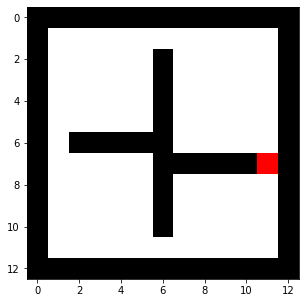

In [18]:
startState = 57
# Simulation
observation = env.reset(startState)
viz.resetMap(phi)

option = policy_over_options.sample(phi)
action = options[option].sample(phi)

for step in range(args.nsteps):
    observation, reward, done, _ = env.step(action)
    phi = features(observation)

    #render
    clear_output(wait=True)
    viz.showMap(phi, option)

    if options[option].terminate(phi):
        option = policy_over_options.sample(phi)

    action = options[option].sample(phi)

    if done:
        break

## Display action and option preference in each state

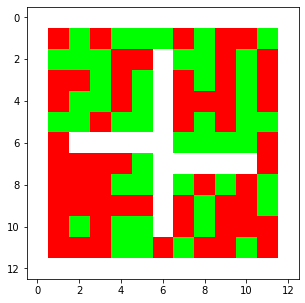

In [11]:
# Display option preference
viz.showPref(policy_over_options.weightsP)

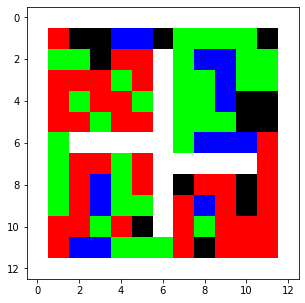

In [16]:
opt = 0
# Display action preference for opt
viz.showPref(options[opt].weightsP)

## Display Attention

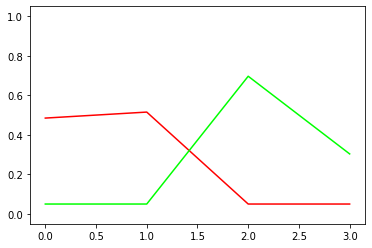

In [17]:
viz.showAttention(options)